# ***Quora Question Pair Similarity***

In [1]:
# https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60

# Glove Vectors
!wget --header="Host: doc-0c-2c-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_quvsv3f7hvua6si0jcsst9neqmqcnn8o_nonce=lctd1g9369de2" --header="Connection: keep-alive" "https://doc-0c-2c-docs.googleusercontent.com/docs/securesc/r5kf5b7cdb9m7vvltocpefcjv36j9hqe/g9cefbhkst947s8th2umapa7mqe0nvqh/1618296975000/06629147635963609455/04779880292502345341/1Z6bjXmyCaoEzXYo_tRDwLTsfeA2F3K3j?e=download&authuser=0&nonce=lctd1g9369de2&user=04779880292502345341&hash=o37ercfp6ibsasaodjq2ufpinihhdfp2" -c -O 'glove_vectors'

--2021-04-13 06:57:33--  https://doc-0c-2c-docs.googleusercontent.com/docs/securesc/r5kf5b7cdb9m7vvltocpefcjv36j9hqe/g9cefbhkst947s8th2umapa7mqe0nvqh/1618296975000/06629147635963609455/04779880292502345341/1Z6bjXmyCaoEzXYo_tRDwLTsfeA2F3K3j?e=download&authuser=0&nonce=lctd1g9369de2&user=04779880292502345341&hash=o37ercfp6ibsasaodjq2ufpinihhdfp2
Resolving doc-0c-2c-docs.googleusercontent.com (doc-0c-2c-docs.googleusercontent.com)... 172.217.2.97, 2607:f8b0:4004:80a::2001
Connecting to doc-0c-2c-docs.googleusercontent.com (doc-0c-2c-docs.googleusercontent.com)|172.217.2.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘glove_vectors’

glove_vectors           [          <=>       ] 121.60M  41.1MB/s    in 3.0s    

2021-04-13 06:57:37 (41.1 MB/s) - ‘glove_vectors’ saved [127506004]



In [48]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
df = pd.read_csv('/content/drive/MyDrive/AppliedAI/Quora Question Pair Similarity/train.csv', encoding = 'latin-1')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [51]:
df['question1'] = df['question1'].apply(lambda x : str(x).lower())
df['question2'] = df['question2'].apply(lambda x : str(x).lower())

In [52]:
print('Number of data points:', df.shape[0])

Number of data points: 404290


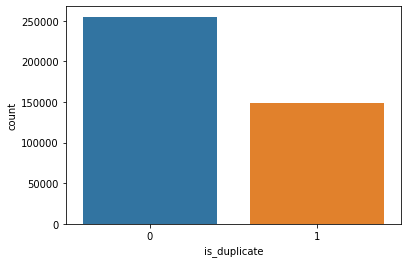

In [53]:
sns.countplot(df['is_duplicate'])
plt.show()

In [54]:
print('Percentage of similar questions:', round(100*(len(df.loc[df['is_duplicate'] == 1])/len(df)), 3))
print('Percentage of unsimilar questions:', round(100*(len(df.loc[df['is_duplicate'] == 0])/len(df)), 3))

Percentage of similar questions: 36.92
Percentage of unsimilar questions: 63.08


In [55]:
print('Total number of unique questions:', len(np.unique(list(df['qid1']) + list(df['qid2']))))

Total number of unique questions: 537933


In [56]:
value_counts = pd.Series(list(df['qid1']) + list(df['qid2'])).value_counts()
print('Questions that appear more than once:', np.sum(value_counts > 1))

Questions that appear more than once: 111780


In [57]:
print('Percentage of repeating questions:', round(100*(np.sum(value_counts > 1)/len(np.unique(list(df['qid1']) + list(df['qid2'])))), 3))

Percentage of repeating questions: 20.78


In [58]:
df.fillna('', axis = 1, inplace = True)

In [59]:
print('Analysis of null values:\n')
df.isnull().sum()

Analysis of null values:



id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## ***Feature Engineering***

In [60]:
df['qid1_frequency'] = df.groupby('qid1')['qid1'].transform('count')
df['qid2_frequency'] = df.groupby('qid2')['qid2'].transform('count')
df['frequency_difference'] = (df['qid1_frequency'] - df['qid2_frequency'])
df['frequency_sum'] = (df['qid1_frequency'] + df['qid2_frequency'])
df['question1_words'] = df['question1'].apply(lambda x : len(x.split()))
df['question2_words'] = df['question2'].apply(lambda x : len(x.split()))
df['question1_len'] = df['question1'].apply(lambda x : len(x))
df['question2_len'] = df['question2'].apply(lambda x : len(x))

In [61]:
def common_words_len(row):
    w1 = set(row['question1'].split())
    w2 = set(row['question2'].split())
    w3 = w1.intersection(w2)
    return 1.0*len(w3)

def total_words_len(row):
    w1 = set(row['question1'].split())
    w2 = set(row['question2'].split())
    w3 = w1.union(w2)
    return 1.0*len(w3)

def words_ratio(row):
    w1 = set(row['question1'].split())
    w2 = set(row['question2'].split())
    return 1.0*(len(w1.intersection(w2))/len(w1.union(w2)))

df['common_words_len'] = df.apply(common_words_len, axis = 1)
df['total_words_len'] = df.apply(total_words_len, axis = 1)
df['words_ratio'] = df.apply(words_ratio, axis = 1)

In [62]:
df['all_questions'] = df['question1'] + ' ' + df['question2']
df.drop(['question1', 'question2'], axis = 1, inplace = True)

In [63]:
# https://gist.github.com/sebleier/554280
# We are removing the following words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [64]:
def preprocess(x):
    text = re.sub(r'\\r', ' ', x)
    text = re.sub(r'\r', ' ', text)
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'@', ' ', text)
    text = re.sub(r'\\t', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\!', ' ', text)
    text = re.sub(r'\$', ' ', text)
    text = re.sub(r'\%', ' ', text)
    text = re.sub(r'\&', ' ', text)
    text = re.sub(r'<.*>', ' ', text)
    text = re.sub(r'>', ' ', text)
    text = re.sub(r'<', ' ', text)
    text = re.sub(r'\(.*\)', ' ', text)
    text = re.sub(r'\(', ' ', text)
    text = re.sub(r'\)', ' ', text)
    text = re.sub(r'\,', ' ', text)
    text = re.sub(r'\-', ' ', text)
    text = re.sub(r'\\', ' ', text)
    text = re.sub(r'\.', ' ', text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r'\"', ' ', text)
    text = re.sub(r'\?', ' ', text)
    text = re.sub(r"\!", " ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.replace('\\"', ' ')
    text = re.sub('\$', ' ', text)
    text = re.sub('\%', ' ', text)
    text = re.sub('\&', 'and', text)
    text = ' '.join(e for e in text.split() if e.lower() not in stopwords)
    text = text.lower()
    return text.strip()

In [65]:
df['all_questions'] = df['all_questions'].apply(preprocess)

## ***Exploratory Data Analysis***

In [66]:
num_cols = ['qid1_frequency', 'qid2_frequency', 'question1_words', 'question2_words', 
            'question1_len', 'question2_len', 'common_words_len', 'total_words_len', 
            'words_ratio', 'frequency_difference', 'frequency_sum']
cat_cols = ['all_questions']

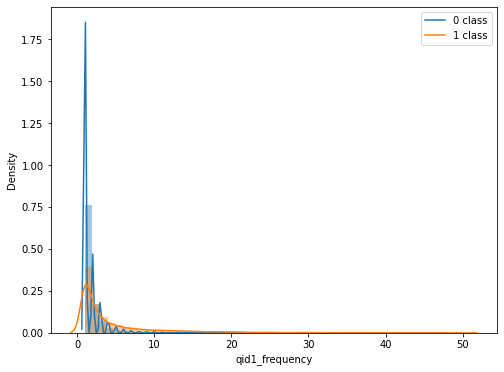

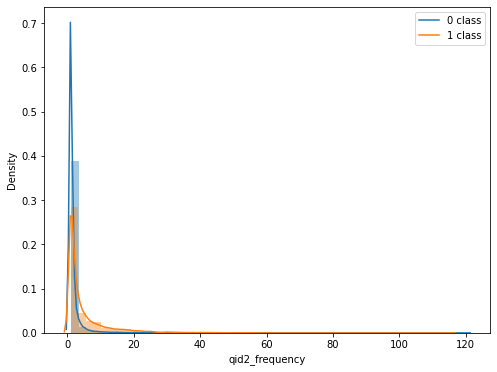

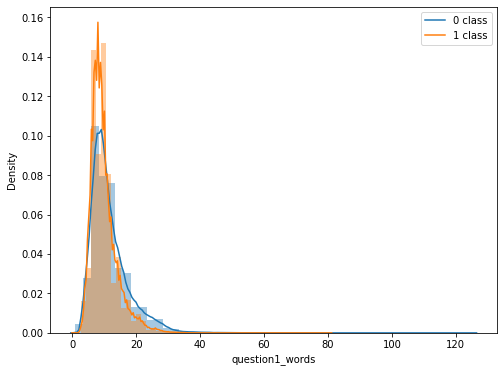

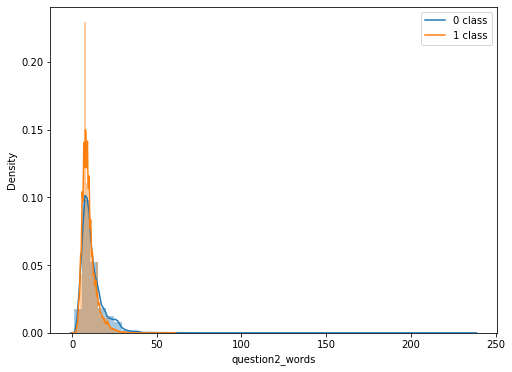

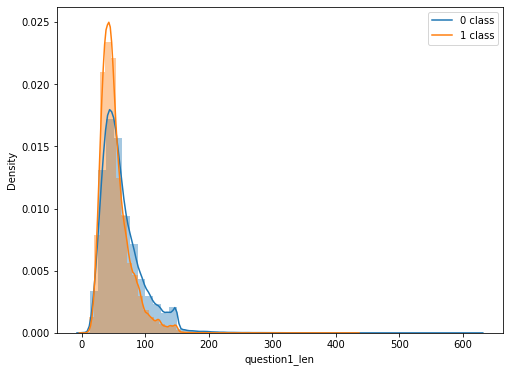

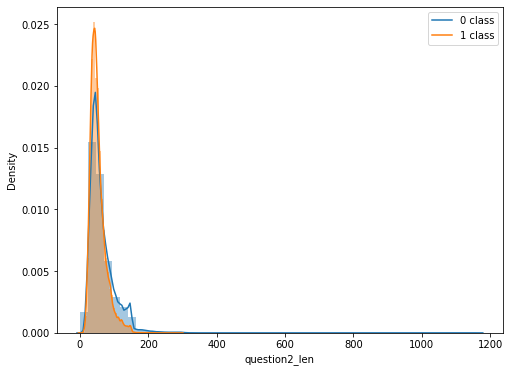

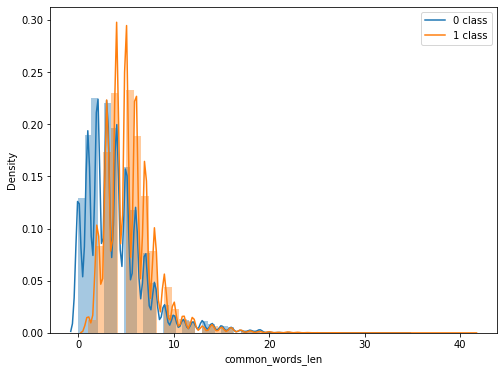

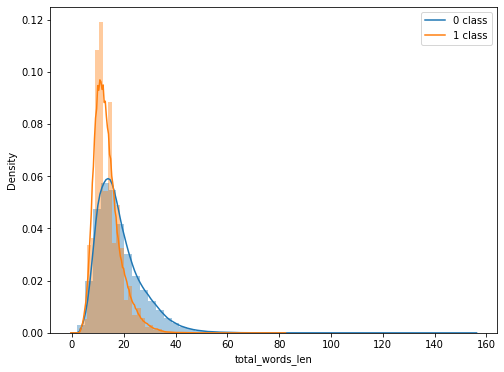

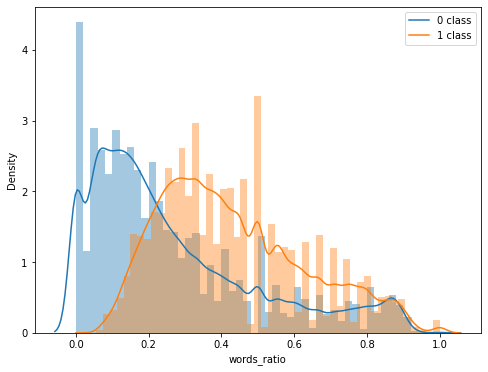

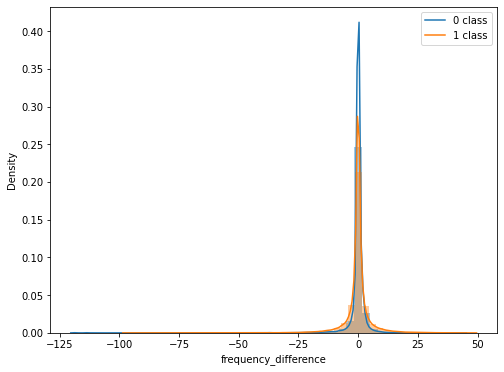

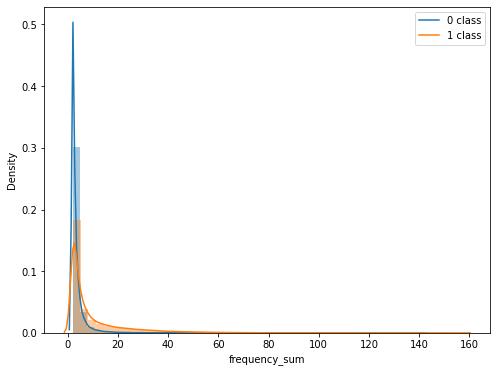

In [67]:
for i in num_cols:
    plt.figure(figsize = (8, 6))
    x = df.loc[df['is_duplicate'] == 0]
    sns.distplot(x[i])
    x = df.loc[df['is_duplicate'] == 1]
    sns.distplot(x[i])
    plt.legend(['0 class', '1 class'])
    plt.show()

*We can see that for all the engineered numerical variables the distributions of variables for both the outputs overlap. Let's see if pairs of these variables can form clusters for our output variable.*

In [68]:
# Custom pairplots for better visualization
pair_cols = []
for i in num_cols:
    for j in num_cols:
        if i != j:
            pair_cols.append([i, j])

k = []
for i in pair_cols:
    if i not in k:
        k.append(i)
        plt.figure(figsize = (8, 6))
        sns.scatterplot(df[i[0]], df[i[1]], hue = df['is_duplicate'])
        plt.show()
    else:
        continue

Output hidden; open in https://colab.research.google.com to view.

*We can observe that by taking 2 features, clusters have started to form. So we can safely assume that by taking more and more features together we can increase the separability of the 2 classes. Hence now we will use Machine Learning models.*

## ***Using Machine Learning methods***

In [69]:
X = df.drop(['is_duplicate', 'id', 'qid1', 'qid2'], axis = 1)
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [70]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train[num_cols] = ss.fit_transform(X_train[num_cols])
X_test[num_cols] = ss.transform(X_test[num_cols])

In [71]:
X_train.head()

,qid1_frequency,qid2_frequency,frequency_difference,frequency_sum,question1_words,question2_words,question1_len,question2_len,common_words_len,total_words_len,words_ratio,all_questions
136385,1.154806,0.823640,0.040321,1.115496,1.118745,-0.187609,1.351863,0.320207,0.158372,0.553562,-0.373401,think first presidential debate hillary clinto...
360960,-0.407055,-0.340038,0.040321,-0.426130,-0.909964,-0.504733,-0.886366,-0.535318,0.158372,-1.083861,1.270449,break relationships exactly break relationship
172180,-0.183932,-0.173798,0.040321,-0.205897,-1.094392,0.129516,-1.120211,0.438211,-0.164705,-0.580039,0.031239,milk vegetarian not logical answer whether mil...
22026,-0.407055,-0.340038,0.040321,-0.426130,2.594170,0.605203,3.022183,0.467712,-0.487783,2.316940,-1.020825,two objects space fall toward meet combined es...
55445,-0.183932,-0.340038,0.222672,-0.316014,0.381033,-0.029046,0.149232,-0.004302,0.804527,-0.076216,0.473814,healthy sleep covering head fully blanket dang...


In [72]:
import pickle

with open('glove_vectors', 'rb') as f:
    glove = pickle.load(f)
    glove_words =  set(glove.keys())

In [76]:
def avg_embedding(x):
    tokens = x.split()
    arr = np.zeros(300)
    for i in tokens:
        if i in glove_words:
            arr += glove[i]
    return arr/(len(tokens) + 1)

In [77]:
embedding_train = X_train['all_questions'].apply(avg_embedding)
embedding_train_matrix = np.zeros((len(X_train), 300))
for i in range(len(X_train)):
    embedding_train_matrix[i] = embedding_train.values[i]
train_data = np.hstack((X_train.drop('all_questions', axis = 1).values, embedding_train_matrix))

embedding_test = X_test['all_questions'].apply(avg_embedding)
embedding_test_matrix = np.zeros((len(X_test), 300))
for i in range(len(X_test)):
    embedding_test_matrix[i] = embedding_test.values[i]
test_data = np.hstack((X_test.drop('all_questions', axis = 1).values, embedding_test_matrix))

*1. Decision Tree Classifier*

In [78]:
dtc = DecisionTreeClassifier()
parameters = {'max_depth':  [1, 5, 10, 50],
              'min_samples_split': [5, 10, 100, 500]}
clf = RandomizedSearchCV(estimator = dtc, param_distributions = parameters, cv = 3, scoring = 'roc_auc', return_train_score = True)
clf.fit(train_data, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [79]:
clf.best_params_

{'max_depth': 10, 'min_samples_split': 100}

In [80]:
clf.best_score_

0.8749510310773555

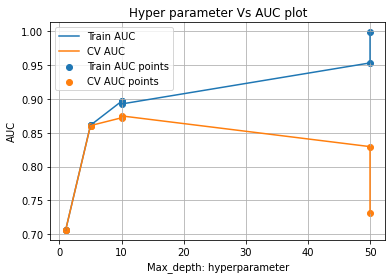

In [81]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std = results['std_test_score']
K =  results['param_max_depth']
plt.plot(K, train_auc, label = 'Train AUC')
plt.plot(K, cv_auc, label = 'CV AUC')
plt.scatter(K, train_auc, label = 'Train AUC points')
plt.scatter(K, cv_auc, label = 'CV AUC points')
plt.legend()
plt.xlabel("Max_depth: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

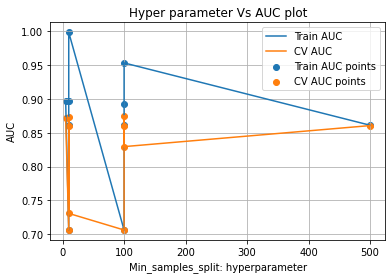

In [82]:
results = results.sort_values(['param_min_samples_split'])
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std = results['std_test_score']
K =  results['param_min_samples_split']
plt.plot(K, train_auc, label = 'Train AUC')
plt.plot(K, cv_auc, label = 'CV AUC')
plt.scatter(K, train_auc, label = 'Train AUC points')
plt.scatter(K, cv_auc, label = 'CV AUC points')
plt.legend()
plt.xlabel("Min_samples_split: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

In [83]:
dtc = DecisionTreeClassifier(max_depth = clf.best_params_['max_depth'], min_samples_split = clf.best_params_['min_samples_split'])
dtc.fit(train_data, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [84]:
y_train_pred = dtc.predict(train_data)
y_test_pred = dtc.predict(test_data)

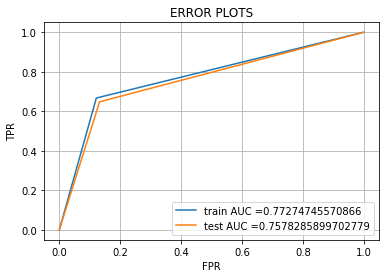

In [85]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label = "train AUC =" + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

AUC Score on Test Data:  0.7578285899702779


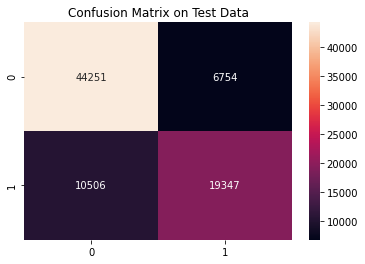

In [86]:
plt.title('Confusion Matrix on Test Data')
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt = 'd')
print('AUC Score on Test Data: ', auc(test_fpr, test_tpr))
plt.show()

In [87]:
print('Accuracy on Train data', accuracy_score(y_train, dtc.predict(train_data)))
print('Accuracy on Test data', accuracy_score(y_test, dtc.predict(test_data)))

Accuracy on Train data 0.8003382472977318
Accuracy on Test data 0.7865393653070816


*2. Logistic Regression*

In [88]:
model = LogisticRegression(random_state = 0)
parameters = {'C':  [0.00001, 0.001, 0.1, 1, 10, 100]}
clf = RandomizedSearchCV(estimator = model, param_distributions = parameters, cv = 3, scoring = 'roc_auc', return_train_score = True)
clf.fit(train_data, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=0,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [1e-05, 0.001, 0.1, 1, 10, 100]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='roc_auc', verbose=0)

In [89]:
clf.best_params_

{'C': 0.1}

In [90]:
clf.best_score_

0.8368232423509383

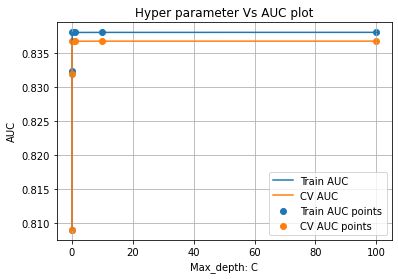

In [91]:
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])
train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std = results['std_test_score']
K =  results['param_C']
plt.plot(K, train_auc, label = 'Train AUC')
plt.plot(K, cv_auc, label = 'CV AUC')
plt.scatter(K, train_auc, label = 'Train AUC points')
plt.scatter(K, cv_auc, label = 'CV AUC points')
plt.legend()
plt.xlabel("Max_depth: C")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

In [92]:
model = LogisticRegression(C = clf.best_params_['C'], random_state = 0).fit(train_data, y_train)
model.fit(train_data, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

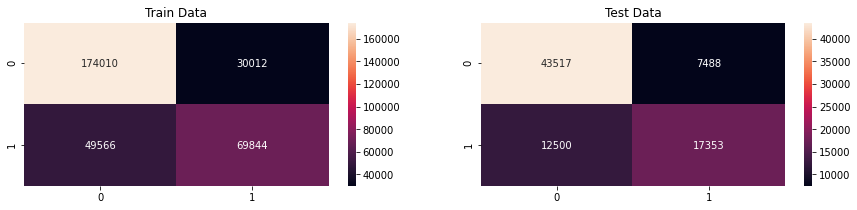

In [93]:
plt.figure(figsize = (15, 3))
plt.subplot(121)
plt.title('Train Data')
sns.heatmap(confusion_matrix(y_train, model.predict(train_data)), annot = True, fmt = 'd')
plt.subplot(122)
plt.title('Test Data')
sns.heatmap(confusion_matrix(y_test, model.predict(test_data)), annot = True, fmt = 'd')
plt.show()

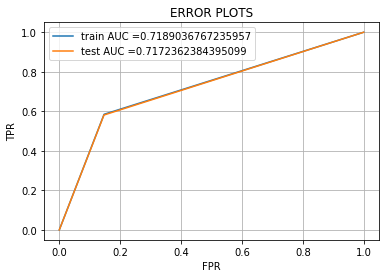

In [94]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, model.predict(train_data))
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, model.predict(test_data))
plt.plot(train_fpr, train_tpr, label = "train AUC =" + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [95]:
print('Accuracy on Train data', accuracy_score(y_train, model.predict(train_data)))
print('Accuracy on Test data', accuracy_score(y_test, model.predict(test_data)))

Accuracy on Train data 0.7539575552202626
Accuracy on Test data 0.7528012070543422


*3. LSTM Model*

In [96]:
from keras.preprocessing.text import Tokenizer

tokenizer_e = Tokenizer(num_words = 8000, filters = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer_e.fit_on_texts(X_train['all_questions'])
all_questions_train = tokenizer_e.texts_to_sequences(X_train['all_questions'])
all_questions_test = tokenizer_e.texts_to_sequences(X_test['all_questions'])

In [97]:
# Mean length of sentences
np.mean(X_train['all_questions'].apply(lambda x : len(x.split())))

11.080041554329814

In [98]:
from keras.preprocessing import sequence

max_text_length = 20
all_questions_train = sequence.pad_sequences(all_questions_train, maxlen = max_text_length, padding = 'post')
all_questions_test = sequence.pad_sequences(all_questions_test, maxlen = max_text_length, padding = 'post')

In [99]:
maximum_words_e = len(tokenizer_e.word_index)
embedding_matrix_e = np.zeros((maximum_words_e + 1, 300))

for word, i in tokenizer_e.word_index.items():
    if word in glove_words:
        embedding_matrix_e[i] = glove[word]

## ***Model building***

In [100]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout,Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.layers import Embedding, Dense
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
import tensorflow as tf
from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

In [101]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [102]:
learning_rate = ReduceLROnPlateau(monitor = 'val_auroc', factor = 0.1, patience = 1, verbose = 1, mode = 'max', min_delta = 0, cooldown = 0, min_lr = 0.0001)
early_stopping = EarlyStopping(monitor = 'val_auroc', min_delta = 0, patience = 0, verbose = 0, mode = 'auto', baseline = None, restore_best_weights = False)

In [103]:
# All Questions
input_all_questions = keras.layers.Input(shape = (20, ))
X_all_questions = Embedding(output_dim = 300, input_dim = maximum_words_e + 1, input_length = 20, trainable = True, weights = [embedding_matrix_e])(input_all_questions)
lstm_all_questions = LSTM(100, activation = 'relu', return_sequences = True)(X_all_questions)
flatten_all_questions = Flatten()(lstm_all_questions)

# Numeric Columns
input_num_cols = keras.layers.Input(shape = (11, ))
layer_num_cols_2 = Dense(16, activation = 'relu', kernel_initializer = 'glorot_normal')(input_num_cols)

# Concatenate
x = concatenate([flatten_all_questions, layer_num_cols_2])

layer1 = Dense(128, activation = 'relu', kernel_initializer = 'glorot_normal')(x)
dropout1 = Dropout(0.3)(layer1)
layer2 = Dense(64, activation = 'relu', kernel_initializer = 'glorot_normal')(dropout1)
dropout2 = Dropout(0.3)(layer2)
layer3 = Dense(32, activation = 'relu', kernel_initializer = 'glorot_normal')(dropout2)

output = Dense(2, activation = 'softmax', name = 'output')(layer3)

In [104]:
total_input = [input_all_questions, input_num_cols]

In [105]:
model1 = Model(inputs = total_input, outputs = output)

In [106]:
train_total = [all_questions_train, X_train[num_cols].values]
test_total = [all_questions_test, X_test[num_cols].values]

In [107]:
from keras.utils import np_utils

adam = tf.keras.optimizers.Adam(0.001)
model1.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy', auroc])
model1.fit(train_total, np_utils.to_categorical(y_train), 
           batch_size = 100, 
           epochs = 10, 
           verbose = 1, 
           validation_data = (test_total, np_utils.to_categorical(y_test)),
           callbacks = [early_stopping, learning_rate])

Epoch 1/10
3235/3235 [==============================] - 966s 298ms/step - loss: 0.4208 - accuracy: 0.7816 - auroc: 0.8652 - val_loss: 0.3598 - val_accuracy: 0.8189 - val_auroc: 0.9070
Epoch 2/10
3235/3235 [==============================] - 947s 293ms/step - loss: 0.3465 - accuracy: 0.8297 - auroc: 0.9160 - val_loss: 0.3511 - val_accuracy: 0.8234 - val_auroc: 0.9124


*The model has validation AUC score of 0.9124 and validation accuracy of 0.8249. As can be seen from the model, the accuracy and AUC on both train and test data are nearly the same. It means our model hasn't overfitted.*

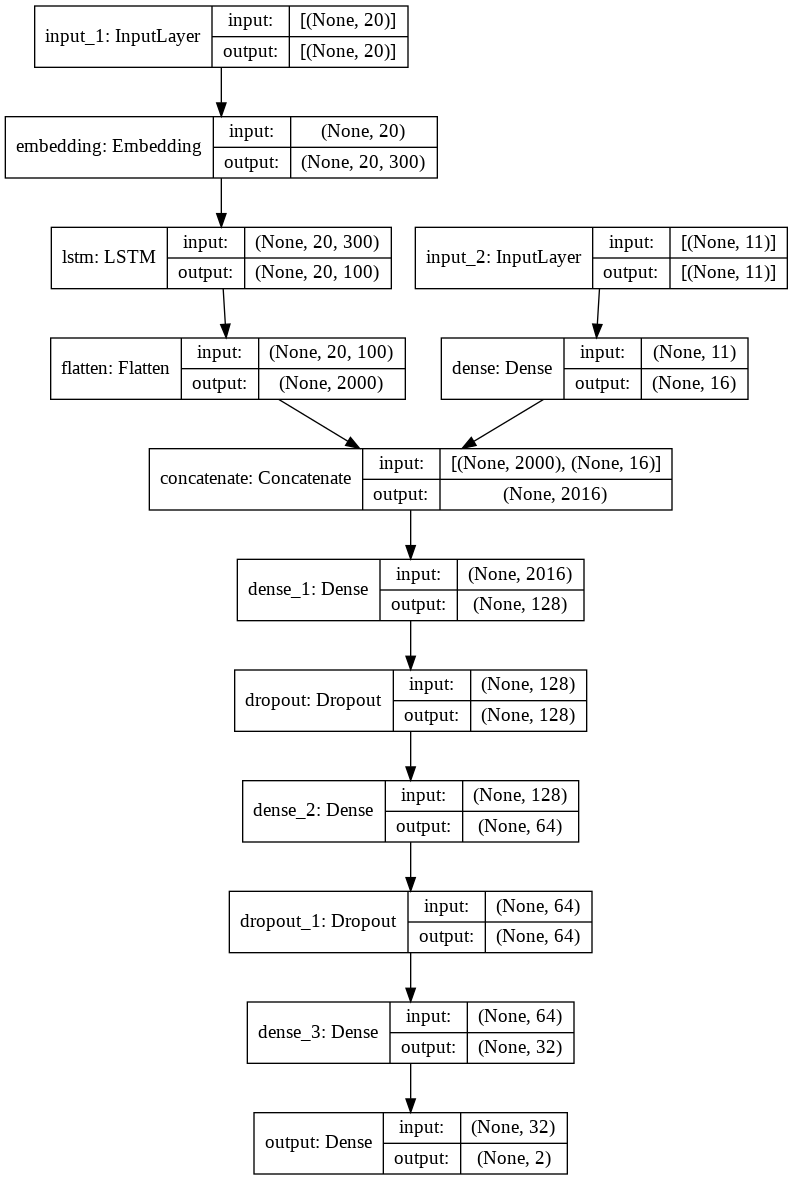

In [108]:
model_1 = 'model_1.png'
tf.keras.utils.plot_model(model1, to_file = model_1, show_shapes = True)

***Conclusion:***


> *All the models have performed brilliantly but the performance of LSTM is by far the best performance.*

